In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/boxoffice/Recruitment x Box Office x Q1 2019.xlsx
/kaggle/input/boxoffice/Recruitment x Box Office x Q1 2019 - Titles Performace.csv
/kaggle/input/boxoffice/Recruitment x Box Office x Q1 2019 - Twitter.csv


In [2]:
import pandas as pd
import numpy as np
from textblob import TextBlob
from datetime import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt


titles = pd.read_csv('../input/boxoffice/Recruitment x Box Office x Q1 2019 - Titles Performace.csv',delimiter = '\t')
twitter = pd.read_csv('../input/boxoffice/Recruitment x Box Office x Q1 2019 - Twitter.csv',delimiter = '\t')
Recruitment = pd.read_excel('../input/boxoffice/Recruitment x Box Office x Q1 2019.xlsx')

# Clean Twitter Data

In [3]:


tw_clean = twitter[['title','post_content','user_followers_count','user_followee_count','user_post_count','post_date_time']]
tw_clean['post_content_blob'] = tw_clean['post_content'].apply(lambda x: TextBlob(x))
tw_clean['post_content_sentiment'] = tw_clean['post_content_blob'].apply(lambda x: x.polarity)
tw_clean['post_content_subjectivity']  = tw_clean['post_content_blob'].apply(lambda x: x.subjectivity)

#----------------------------------------------#
tw4 = tw_clean[['title','post_date_time','user_followers_count','user_followee_count','user_post_count','post_content_sentiment']]
tw4['post_date'] = tw4['post_date_time'].apply(lambda x:datetime.strptime(x[0:10],'%Y-%m-%d'))
tw4 = tw4[['title','post_date','user_followers_count','user_followee_count','user_post_count','post_content_sentiment']]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

**The Feature Sum of Squared Sentiment, is computed for each Title, year and week**

In [4]:
tw4['week']  = tw4['post_date'].apply(lambda x:int(x.strftime("%V")))
tw4['year']  = tw4['post_date'].apply(lambda x:x.year)

tw4["post_content_sentiment2"]  = tw4["post_content_sentiment"]*tw4["post_content_sentiment"]
tw4["idx"]  = range(tw4.shape[0])
tw_agg = tw4.groupby(["title","year","week"]).agg({"post_content_sentiment2":"sum","idx":"count"})
tw_agg.rename({"idx":"tweet_count"},inplace = True, axis =1)
len(tw_agg.reset_index()['title'].unique())

25

# Clean Recruitment Data

In [5]:
Recruitment['Weekend Gross']  = Recruitment['Weekend Gross'].replace('[\$,]', '', regex=True).apply(lambda x: x.replace('AU',''))
Recruitment['Weekend Gross']   = Recruitment['Weekend Gross'].astype(float)

Recruitment.rename({"This Week's Rank":"this_weeks_rank",
                    "Last Week's Rank":"last_weeks_rank",
                   "Title":"title",
                   "Studio":"studio",
                   "Weekend Gross":"weekend_gross",
                   "Weeks Into Release":"weeks_into_release",
                   "Year":"year",
                   "Week":"week",
                   "Select_Studios":"select_studios"},axis = 1, inplace = True)

In [6]:
Recruitment["log_weekend_gross"] = np.where(Recruitment["weekend_gross"]==0.0,0.1,np.log(Recruitment["weekend_gross"]))


/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [7]:
re_tw = Recruitment.merge(tw_agg, on = ['title','week','year'],how = 'inner')
re_tw["log_post_content_sentiment"] = np.log(re_tw["post_content_sentiment2"])
re_tw.rename({'log_post_content_sentiment':'log_sentiment'},axis = 1,inplace = True)

In [8]:
re_tw["weeks_into_release"] = np.where(re_tw["weeks_into_release"]=="-",0.,re_tw["weeks_into_release"])
re_tw["weeks_into_release"] =re_tw["weeks_into_release"].astype(float)

# Correlation Analysis between log weekend gross sales and log sentiment

Visualizing the trend between week_into_release, log sentiment and log_weekend_gross for three movies: Black Panther, Dunkirk and Star Wars: The Last Jedi. 
we see that both log_weekend_gross and log_sentiment decrease with increase in week of release. Both of them are strongly correlated with week of release

Text(0, 0.5, 'log_weekend_sales')

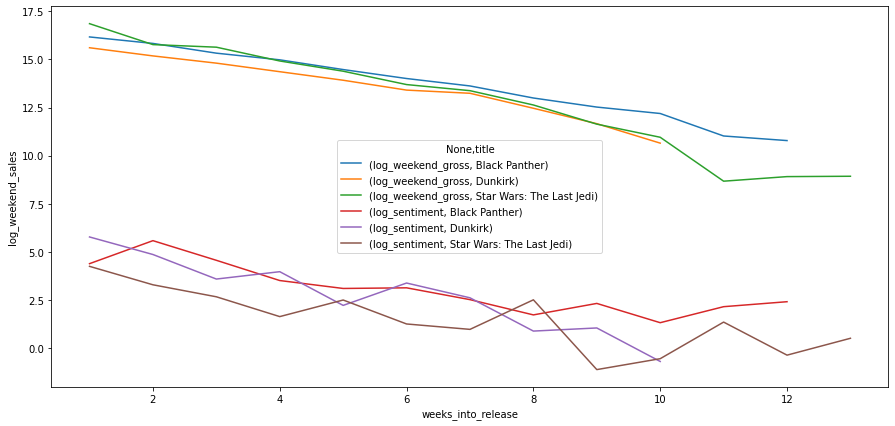

In [9]:

fig, ax =plt.subplots(figsize=(15,7))
black_panther = re_tw.loc[re_tw["title"]=="Black Panther"]
star_wars = re_tw.loc[re_tw["title"]=="Star Wars: The Last Jedi"]
Dunkirk = re_tw.loc[re_tw["title"]=="Dunkirk"]
df_C = pd.concat([black_panther,star_wars,Dunkirk])
df_C.set_index("weeks_into_release")
df_C.groupby(['weeks_into_release','title']).mean()[['log_weekend_gross','log_sentiment']].unstack().plot(ax=ax)
plt.ylabel("log_weekend_sales")

In [10]:
cols = ['this_weeks_rank',
 'last_weeks_rank',
 'weeks_into_release',
 'log_sentiment',
 'tweet_count',
 'log_weekend_gross']

re_tw2 = re_tw[cols]

re_tw2.corr()

,weeks_into_release,log_sentiment,tweet_count,log_weekend_gross
weeks_into_release,1.000000,-0.477334,-0.410144,-0.565084
log_sentiment,-0.477334,1.000000,0.562468,0.711906
tweet_count,-0.410144,0.562468,1.000000,0.359709
log_weekend_gross,-0.565084,0.711906,0.359709,1.000000


# Perform Linear Regression to identify significance of Sentiment and week of Release

**When log_weekend_gross ~ week_into_release + log_sentiment


We see that the p values for log sentiment for all movies are not significant. This shows that the correlation seen with log_weekend_gross and log_sentiment is spurious (erroneus) and is due to the fact that both these variables vary linearly with time.

In [11]:

corr_s = {}
corr_t = {}
corr_w = {}
coef_sent = {}
pval_sent = {}
coef_week = {}
pval_week = {}

for i in re_tw.title.unique():
    title_df = re_tw[re_tw['title']==i][cols]
    corr_sentiment = title_df.corr().iloc[1,3]
    corr_count = title_df.corr().iloc[2,3]
    corr_week = title_df.corr().iloc[0,3]
    corr_s[i] = corr_sentiment
    corr_t[i] = corr_count
    corr_w[i] = corr_week
    X = title_df[['weeks_into_release','log_sentiment']]
    Y = title_df['log_weekend_gross']
    X = sm.add_constant(X)
    model = sm.OLS(Y, X).fit()
    #print(i,len(model.params))
    coef_sent[i] = model.params['log_sentiment']
    pval_sent[i] = model.pvalues['log_sentiment']
    coef_week[i] = model.params['weeks_into_release']
    pval_week[i] = model.pvalues['weeks_into_release']

/opt/conda/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1620: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/opt/conda/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1620: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


In [12]:
pval_sent

{'Star Wars: The Last Jedi': 0.36020440367565154,
 'The Greatest Showman': 0.17649761073802278,
 'Coco': 0.08073107803987206,
 'Overlord': nan,
 'Strange Colours': nan,
 'The Meg': 0.14323987860235768,
 'Incredibles 2': 0.2834179921072054,
 'Black Panther': 0.07185537630760187,
 'Dunkirk': 0.28861996145446567,
 'Wonder Woman': 0.41306893195739713}

In [13]:
pval_week

{'Star Wars: The Last Jedi': 4.0213816618309146e-07,
 'The Greatest Showman': 0.0026290995646676345,
 'Coco': 0.0006829709497703358,
 'Overlord': nan,
 'Strange Colours': nan,
 'The Meg': 0.03211926686656134,
 'Incredibles 2': 7.169848624673953e-05,
 'Black Panther': 1.332548708843341e-08,
 'Dunkirk': 0.0050182371868473345,
 'Wonder Woman': 0.002408630696985615}

# Plot Correlation Charts

 **Does the correlation vary across Movie Studios and movie genres?
 
 There is no evidence that there is any differential behaviour for correlation across different types of movies

In [14]:
corr_s2 =  pd.DataFrame.from_dict(corr_s,orient='index',columns=['corr'])
corr_t2 =  pd.DataFrame.from_dict(corr_t,orient='index',columns = ['count'])
corr_s2.reset_index(inplace = True)
corr_t2.reset_index(inplace = True)

re_tw2 = re_tw.merge(corr_s2,how = 'left',left_on = 'title',right_on='index')
re_tw2 = re_tw2.merge(corr_t2,how = 'left',left_on = 'title',right_on='index')



In [15]:
corr_s2

,index,corr
0,Star Wars: The Last Jedi,0.745972
1,The Greatest Showman,0.973062
2,Coco,0.386649
3,Overlord,1.000000
4,Strange Colours,NaN
5,The Meg,0.781691
6,Incredibles 2,0.932551
7,Black Panther,0.824680
8,Dunkirk,0.954287
9,Wonder Woman,0.887504


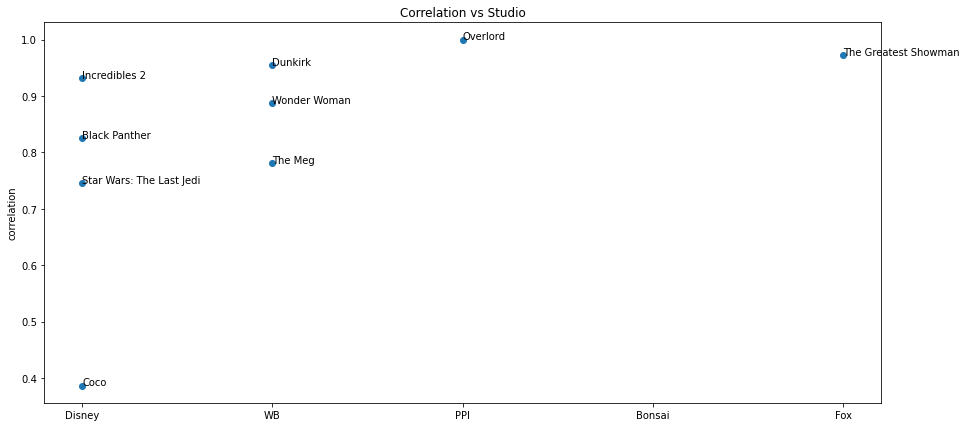

In [16]:
import matplotlib.pyplot as plt
re_tw3 = re_tw2[['title','studio','log_weekend_gross',
                'log_sentiment','corr','count','year','week','weeks_into_release']]
title_corr = re_tw3.groupby('title').agg({"studio":"max","corr":"mean","count":"mean"})
ax, fig = plt.subplots(figsize = (15,7))
X = title_corr['studio']
y = title_corr["corr"]
plt.scatter(X,y)
plt.title("Correlation vs Studio")
plt.ylabel("correlation")
movies = title_corr.index
for i, txt in enumerate(movies):
    plt.annotate(txt, (X[i], y[i]))

# Correlation for Weeks into Release and Gross Sales

**Does the Correlation of log_sentiment vary with log_gross vary across week_of_release?**

The data suggests a strong positive correlation between log sentiment and week_of_release. For each week_of_release. The datapoints for weeks 11, 12 and 13 may be ignored as the number of datapoints are very small

In [17]:
import statsmodels.api as sm

corr2_s = {}
corr2_t = {}
corr2_w = {}
coef2_sent = {}
pval2_sent = {}
coef2_week = {}
pval2_week = {}

for i in re_tw.weeks_into_release.unique():
    week_df = re_tw[re_tw['weeks_into_release']==i][cols]
    corr_sentiment = week_df.corr().iloc[1,3]
    corr_count = week_df.corr().iloc[2,3]
    corr_week = week_df.corr().iloc[0,3]
    corr2_s[i] = corr_sentiment
    corr2_t[i] = corr_count
    corr2_w[i] = corr_week
    X = week_df[['log_sentiment']]
    Y = week_df['log_weekend_gross']
    X = sm.add_constant(X)
    print(i,X.shape)
    model = sm.OLS(Y, X).fit()
    #print(i,len(model.params))
    coef2_sent[i] = model.params['log_sentiment']
    pval2_sent[i] = model.pvalues['log_sentiment']


4.0 (8, 2)
2.0 (9, 2)
1.0 (10, 2)
10.0 (7, 2)
7.0 (7, 2)
6.0 (7, 2)
5.0 (8, 2)
3.0 (8, 2)
12.0 (3, 2)
11.0 (4, 2)
9.0 (6, 2)
8.0 (6, 2)
13.0 (1, 1)


/opt/conda/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1620: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


In [18]:
corr2_s2 =  pd.DataFrame.from_dict(corr2_s,orient='index',columns=['corr_week'])
corr2_t2 =  pd.DataFrame.from_dict(corr2_t,orient='index',columns = ['count_week'])
corr2_s2.reset_index(inplace = True)
corr2_t2.reset_index(inplace = True)

re_tw2 = re_tw.merge(corr2_s2,how = 'left',left_on = 'weeks_into_release',right_on='index')
re_tw2 = re_tw2.merge(corr2_t2,how = 'left',left_on = 'weeks_into_release',right_on='index')

Text(0.5, 0, 'weeks_into_release')

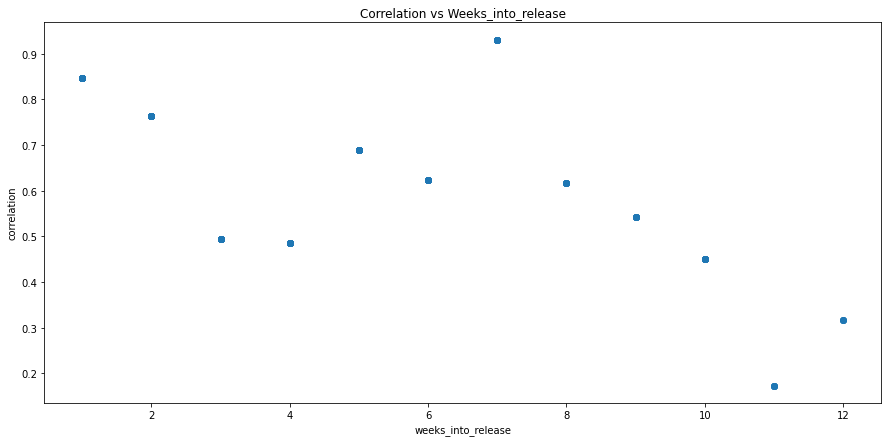

In [19]:
import matplotlib.pyplot as plt

ax, fig = plt.subplots(figsize = (15,7))
#re_tw3.set_index("studio",inplace = True)
#re_tw3['corr'].plot(kind = 'scatter')

X = re_tw2['weeks_into_release']
y = re_tw2["corr_week"]
plt.scatter(X,y)
plt.title("Correlation vs Weeks_into_release")
plt.ylabel("correlation")
plt.xlabel("weeks_into_release")

In [20]:
model.params

log_sentiment    17.548042
dtype: float64

# Analysis of Titles Data

In [21]:
def parse_start_date(x):
    if x[0]=='Jan':
        m='01'
    elif x[0]=="Feb":
        m='02'
    elif x[0]=='Mar':
        m='03'
    elif x[0]== 'Apr':
        m='04'
    elif x[0] == 'May':
        m='05'
    elif x[0]== 'Jun':
        m='06'
    elif x[0]== 'Jul':
        m='07'
    elif x[0]=='Aug':
        m='08'
    elif x[0]=='Sep':
        m='09'
    elif x=='Oct':
        m='10'
    elif x[0]=='Nov':
        m='11'
    else:
        m ='12'
    d1 = x[1].split("–")[0]
    d2 = x[1].split("–")[1]
    total_day = m + "-" + d1
    return total_day


def parse_end_date(x):
    if x[0]=='Jan':
        m='01'
    elif x[0]=="Feb":
        m='02'
    elif x[0]=='Mar':
        m='03'
    elif x[0]== 'Apr':
        m='04'
    elif x[0] == 'May':
        m='05'
    elif x[0]== 'Jun':
        m='06'
    elif x[0]== 'Jul':
        m='07'
    elif x[0]=='Aug':
        m='08'
    elif x[0]=='Sep':
        m='09'
    elif x=='Oct':
        m='10'
    elif x[0]=='Nov':
        m='11'
    else:
        m ='12'
    d1 = x[1].split("–")[0]
    d2 = x[1].split("–")[1]
    if len(x)==3:
        d3=x[2]
    if len(x)==2:
        total_day = m + "-" + d2
    elif len(x)==3:
        total_day = m + "-"+d3
    return total_day




In [22]:
titles['Weekend Gross']  = titles['Weekend Gross'].replace('[\$,]', '', regex=True).astype('float64')
titles['Gross-to-Date']  = titles['Gross-to-Date'].replace('[\$,]', '', regex=True).astype('float64')


In [23]:
from datetime import datetime 
import numpy as np
titles['Date2'] = titles['Date'].apply(lambda x:x.replace(".","").split())
titles['Date-m-d1'] = titles['Date2'].apply(lambda x:parse_start_date(x))
titles['Date-m-d2'] = titles['Date2'].apply(lambda x:parse_end_date(x))


options = [(titles['Year']==2017),(titles['Year']==2018),(titles['Year']==2019)]
outputs_start = [pd.Series(np.repeat(['2017-'],titles.shape[0]))+ titles['Date-m-d1'],
                pd.Series(np.repeat(['2018-'],titles.shape[0]))+ titles['Date-m-d1'],
                pd.Series(np.repeat(['2019-'],titles.shape[0]))+ titles['Date-m-d1']]
titles['start_date'] = np.select(options, outputs_start)



outputs_end = [pd.Series(np.repeat(['2017-'],titles.shape[0]))+ titles['Date-m-d2'],
                pd.Series(np.repeat(['2018-'],titles.shape[0]))+ titles['Date-m-d2'],
                pd.Series(np.repeat(['2019-'],titles.shape[0]))+ titles['Date-m-d2']]
titles['start_date'] = np.select(options, outputs_start)
titles['end_date'] = np.select(options, outputs_end)

titles['start_date']  = titles['start_date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d').date())
titles['end_date']  = titles['end_date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d').date())

titles2 = titles[['Title',
# 'Date',
 'Year',
 'Rank',
 'Weekend Gross',
 'Gross-to-Date',
 'Week # of release',
# 'Date2',
# 'Date-m-d1',
# 'Date-m-d2',
 'start_date',
 'end_date']]


In [24]:
titles2.rename({'Weekend Gross':'Weekend_Gross','Week # of release':'Week_of_release', 'Gross-to-Date':'Gross_to_Date','Title':'title'},inplace = True,axis = 1)
titles2['weeks_into_release'] = titles2['start_date'].apply(lambda x:int(x.strftime("%V")))
titles2.loc[titles2["title"] == 'Black Panther']
titles2['log_gross_to_date'] = np.where(titles2['Gross_to_Date']!=0.0,
                                            np.log(titles2['Gross_to_Date']),titles2['Gross_to_Date'])

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

In [25]:
from datetime import timedelta
tw_agg2 = tw4.groupby(["title","post_date"]).agg({"post_content_sentiment2":"sum","idx":"count"})
tw_agg2.rename({"idx":"tweet_count"},inplace = True, axis =1)
tw_agg2 = tw_agg2.reset_index()
tw_agg2.sort_values(['post_date'],ascending = True)
tw_agg2['cum_sentiment'] = tw_agg2.groupby(['title'])['post_content_sentiment2'].apply(lambda x:x.cumsum())
tw_agg2 = tw_agg2.reset_index()


In [26]:

df_j = titles2.merge(tw_agg2, on= ['title'],how = 'left')
df_j =  df_j[(df_j["post_date"]>=df_j["start_date"]) & ((df_j["post_date"]<=df_j["end_date"]))]
df_j['log_post_content_sentiment']  = np.where(df_j['post_content_sentiment2']!=0.,
                                               np.log(df_j['post_content_sentiment2']),
                                              0.01)
df_j['cum_log_sentiment']  = np.where(df_j['cum_sentiment']!=0.,
                                               np.log(df_j['cum_sentiment']),
                                              0.01)

df_j["weeks_into_release"]  = df_j["weeks_into_release"].astype(float)

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [27]:
cols2 = ['weeks_into_release','log_post_content_sentiment','tweet_count','log_gross_to_date','cum_log_sentiment']
title_df = df_j[df_j['title']=='Incredibles 2'][cols2]
title_df.corr()


,weeks_into_release,log_post_content_sentiment,tweet_count,log_gross_to_date,cum_log_sentiment
weeks_into_release,1.000000,-0.960913,-0.826809,0.826389,0.796857
log_post_content_sentiment,-0.960913,1.000000,0.752152,-0.750089,-0.708586
tweet_count,-0.826809,0.752152,1.000000,-0.996127,-0.995602
log_gross_to_date,0.826389,-0.750089,-0.996127,1.000000,0.995311
cum_log_sentiment,0.796857,-0.708586,-0.995602,0.995311,1.000000


In [28]:
df_j["title"].unique()

array(['Incredibles 2', 'The Greatest Showman', 'Jurassic World',
       'Star Wars: The Last Jedi', 'Coco', 'Overlord', 'Dunkirk',
       'The Meg'], dtype=object)

Text(0, 0.5, 'log_weekend_sales')

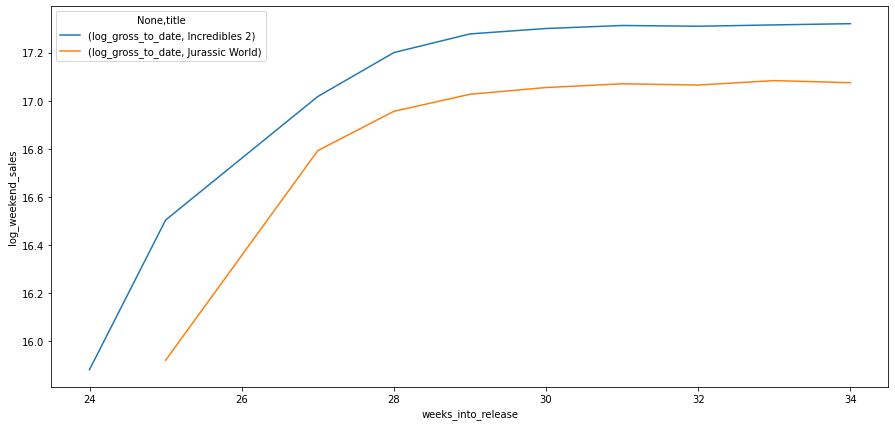

In [29]:
fig, ax =plt.subplots(figsize=(15,7))
incredibles = df_j.loc[df_j["title"]=="Incredibles 2"]
jurrassic = df_j.loc[df_j["title"]=="Jurassic World"]
df_C = pd.concat([incredibles,jurrassic])
df_C.set_index("weeks_into_release")
df_C.groupby(['weeks_into_release','title']).mean()[['log_gross_to_date']].unstack().plot(ax=ax)
plt.ylabel("log_weekend_sales")